In [4]:
from fastai.vision.all import *
from pathlib import Path

In [5]:
path = untar_data(URLs.PASCAL_2007)

In [6]:
df = pd.read_csv(path/'train.csv')

In [7]:
dblock = DataBlock()

In [8]:
dsets = dblock.datasets(df)

In [9]:
dsets.train[0]

(fname       003343.jpg
 labels             dog
 is_valid         False
 Name: 1682, dtype: object,
 fname       003343.jpg
 labels             dog
 is_valid         False
 Name: 1682, dtype: object)

In [10]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

In [11]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   get_x = get_x, 
                   get_y = get_y)

In [12]:
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
                      1., 0., 0., 0., 0.]))

In [13]:
def splitter(df):
    train = df.index[~df['is_valid']].to_list()
    valid = df.index[df['is_valid']].to_list()
    return train,valid

In [14]:
dblock = DataBlock(blocks=(ImageBlock,MultiCategoryBlock),
                  splitter = splitter, 
                  get_x = get_x,
                  get_y = get_y,
                  item_tfms = RandomResizedCrop(128,min_scale=0.35))

In [15]:
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

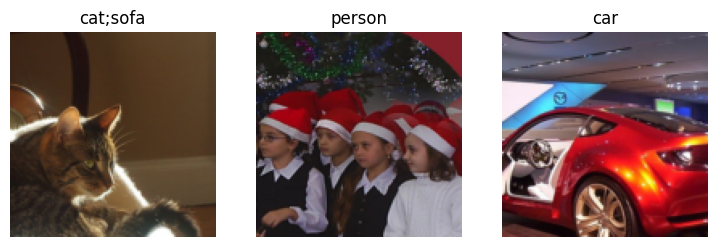

In [16]:
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [17]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [32]:
learn = vision_learner(dls, resnet34, metrics=partial(accuracy_multi,thresh=0.6))

In [33]:
learn.fine_tune(6, base_lr=3e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.972757,0.715877,0.717928,00:13
1,0.817410,0.466946,0.886892,00:12
2,0.519176,0.158455,0.950458,00:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.173887,0.129617,0.955120,00:13
1,0.148148,0.117880,0.957430,00:12
2,0.125924,0.112850,0.959681,00:13
3,0.107345,0.110506,0.960379,00:12
4,0.089992,0.107793,0.962052,00:12
5,0.080612,0.107692,0.961813,00:13


In [34]:
learn.metrics = partial(accuracy_multi, thresh=0.6)
learn.validate()

(#2) [0.10769237577915192,0.9618127942085266]

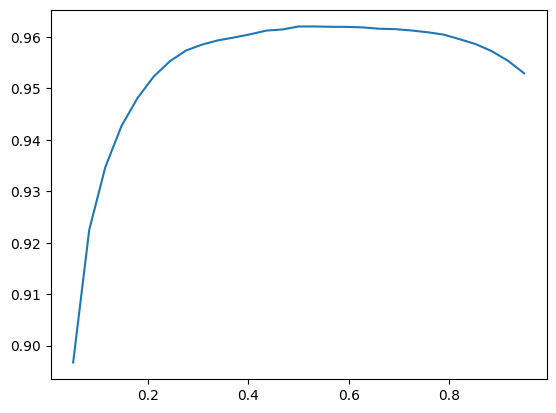

In [35]:
preds, targs = learn.get_preds()
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)